In [2]:
# Packages and adjustments to the figures
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math

In [38]:
# Low-pass filter
w0 = 2*np.pi*80; # pole frequency (rad/s)
num = w0        # transfer function numerator coefficients
den = [1,w0]    # transfer function denominator coefficients
lowPass = signal.TransferFunction(num,den) # Transfer function

In [39]:
samplingFreq = 1e3
dt = 1.0/samplingFreq
discreteLowPass = lowPass.to_discrete(dt,method='gbt',alpha=0.5)

In [40]:
b = discreteLowPass.num;
a = -discreteLowPass.den;
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

Filter coefficients b_i: [0.20084864 0.20084864]
Filter coefficients a_i: [0.59830271]


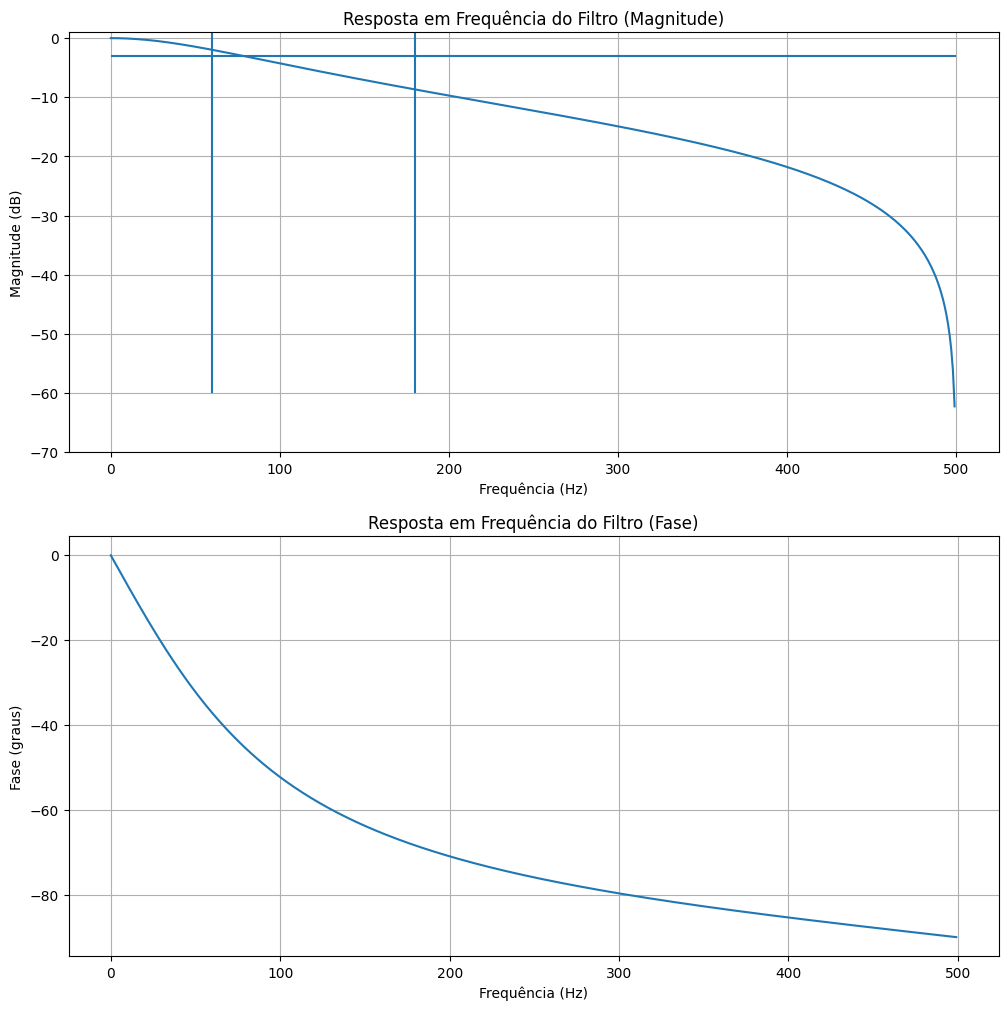

In [41]:
f, h = signal.freqz(discreteLowPass.num, discreteLowPass.den, fs=samplingFreq)

fig, axs  = plt.subplots(2, 1, figsize=(12, 12))
axs[0].plot(f, 20 * np.log10(abs(h)))
axs[0].set_title('Resposta em Frequência do Filtro (Magnitude)')
axs[0].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].set_ylim(-70, 1)
axs[0].hlines(-3, 0, 500)
axs[0].vlines(60, -60, 5)
axs[0].vlines(180, -60, 5)

axs[0].grid()

axs[1].plot(f, np.angle(h)*180/np.pi)
axs[1].set_title('Resposta em Frequência do Filtro (Fase)')
axs[1].set_xlabel('Frequência (Hz)')
axs[1].set_ylabel('Fase (graus)')
axs[1].grid()


In [48]:
# Butterworth filter
wc = 2*np.pi*80; # cutoff frequency (rad/s)
n = 2; # Filter order

# Compute the Butterworth filter coefficents
a = np.zeros(n+1);
gamma = np.pi/(2.0*n);
a[0] = 1; # first coef is always 1
for k in range(0,n):
    rfac = np.cos(k*gamma)/np.sin((k+1)*gamma);
    a[k+1] = rfac*a[k]; # Other coefficients by recursion

print("Butterworth polynomial coefficients a_i:                " + str(a))

# Adjust the cutoff frequency
c = np.zeros(n+1);
for k in range(0,n+1):
    c[n-k] = a[k]/pow(wc,k)

print("Butterworth coefficients with frequency adjustment c_i: " + str(c))

Butterworth polynomial coefficients a_i:                [1.         1.41421356 1.        ]
Butterworth coefficients with frequency adjustment c_i: [3.95785874e-06 2.81348849e-03 1.00000000e+00]


b = [0.04452675 0.08905349 0.04452675]
a = [ 1.32079107 -0.49889805]


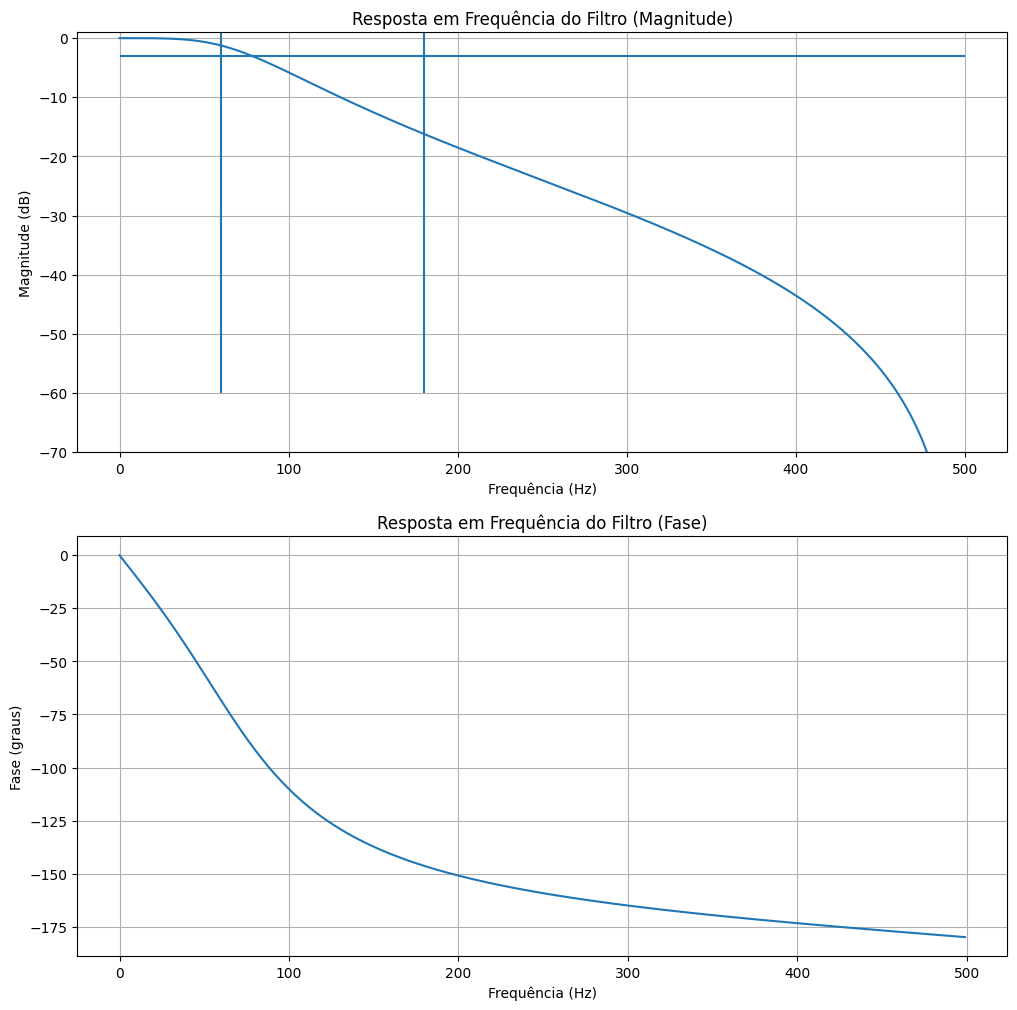

In [50]:
# Low-pass filter
w0 = 2*np.pi*80; # pole frequency (rad/s)
num = [1];      # transfer function numerator coefficients
den = c;        # transfer function denominator coefficients
lowPass = signal.TransferFunction(num,den) # Transfer function
discreteLowPass = lowPass.to_discrete(dt,method='gbt',alpha=0.5)
print(f'b = {discreteLowPass.num}')
print(f'a = {-discreteLowPass.den[1:]}')

f, h = signal.freqz(discreteLowPass.num, discreteLowPass.den, fs=samplingFreq)

fig, axs  = plt.subplots(2, 1, figsize=(12, 12))
axs[0].plot(f, 20 * np.log10(abs(h)))
axs[0].set_title('Resposta em Frequência do Filtro (Magnitude)')
axs[0].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].set_ylim(-70, 1)
axs[0].hlines(-3, 0, 500)
axs[0].vlines(60, -60, 5)
axs[0].vlines(180, -60, 5)
axs[0].grid()

axs[1].plot(f, np.angle(h)*180/np.pi)
axs[1].set_title('Resposta em Frequência do Filtro (Fase)')
axs[1].set_xlabel('Frequência (Hz)')
axs[1].set_ylabel('Fase (graus)')
axs[1].grid()

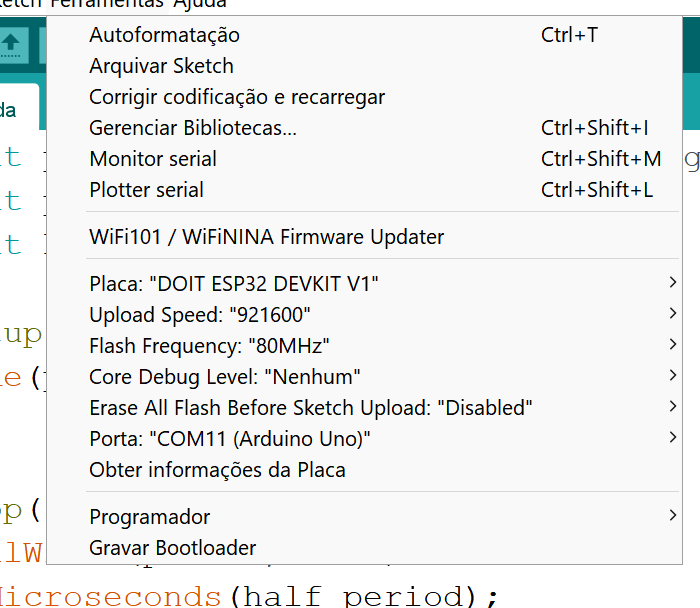